## Imports

In [1]:
%load_ext autoreload
%autoreload 2
# add source folders to path
import sys,os
SRC = '..\src'
src_folders = list(filter(lambda x: os.path.isdir(os.path.join(SRC,x)),os.listdir(SRC)))
[sys.path.append(os.path.join(SRC,folder)) for folder in src_folders]

# import custom libraries
from preamble import *
from helpers import save_joblib

# notebook imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import pickle
import os

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("🔧 Environment Setup Complete")
print(f"   • TensorFlow version: {tf.__version__}")
print(f"   • NumPy version: {np.__version__}")
print(f"   • Pandas version: {pd.__version__}")

# custom file paths

# get data files
files_dict = walk_directory(raw_data)

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\sesa703683\AppData\Local\Temp\ipykernel_17032\3146712581.py:5: SyntaxWarning: invalid escape sequence '\s'
  SRC = '..\src'


🔧 Environment Setup Complete
   • TensorFlow version: 2.20.0-rc0
   • NumPy version: 2.3.0
   • Pandas version: 2.3.0
annual_boiler_analysis c:\Users\sesa703683\Documents\workspace\SootblowingDemoJune2025\data\raw\annual_boiler_analysis.png
boiler_analysis_report_20250812_114613 c:\Users\sesa703683\Documents\workspace\SootblowingDemoJune2025\data\raw\boiler_analysis_report_20250812_114613.txt
boiler_analysis_report_20250813_115621 c:\Users\sesa703683\Documents\workspace\SootblowingDemoJune2025\data\raw\boiler_analysis_report_20250813_115621.txt
massachusetts_boiler_annual_20250812_113312 c:\Users\sesa703683\Documents\workspace\SootblowingDemoJune2025\data\raw\massachusetts_boiler_annual_20250812_113312.csv
massachusetts_boiler_annual_20250813_101638 c:\Users\sesa703683\Documents\workspace\SootblowingDemoJune2025\data\raw\massachusetts_boiler_annual_20250813_101638.csv
massachusetts_boiler_annual_20250813_103438 c:\Users\sesa703683\Documents\workspace\SootblowingDemoJune2025\data\raw\ma

In [2]:
boiler_simulation_file = files_dict['massachusetts_boiler_annual_20250813_115553']
boiler_metadata_file = files_dict['massachusetts_boiler_annual_metadata_20250813_115553']

In [3]:
# %%
# =============================================================================
# 2. CONFIGURATION AND PARAMETERS
# =============================================================================

class Config:
    """Configuration parameters for the LSTM model"""
    
    # Data parameters
    CSV_FILE = boiler_simulation_file
    METADATA_FILE = boiler_metadata_file
    
    # Model parameters
    SEQUENCE_LENGTH = 24  # Hours of history to use for prediction
    PREDICTION_HORIZON = 1  # Hours ahead to predict
    
    # Training parameters
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.1
    EPOCHS = 100
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    
    # Model architecture
    LSTM_UNITS = [128, 64, 32]  # LSTM layer sizes
    DENSE_UNITS = [64, 32]      # Dense layer sizes
    DROPOUT_RATE = 0.2
    RECURRENT_DROPOUT = 0.2
    L2_REGULARIZATION = 0.001
    
    # Maintenance thresholds
    MAINTENANCE_THRESHOLD = 0.15  # 15% degradation triggers maintenance alert
    WARNING_THRESHOLD = 0.10      # 10% degradation triggers warning
    
    # Tube sections in the boiler
    TUBE_SECTIONS = [
        'furnace_walls',
        'generating_bank', 
        'superheater_primary',
        'superheater_secondary',
        'economizer_primary',
        'economizer_secondary',
        'air_heater'
    ]

config = Config()

print("⚙️ Configuration Set")
print(f"   • Sequence length: {config.SEQUENCE_LENGTH} hours")
print(f"   • Prediction horizon: {config.PREDICTION_HORIZON} hour(s)")
print(f"   • Tube sections: {len(config.TUBE_SECTIONS)}")
print(f"   • Maintenance threshold: {config.MAINTENANCE_THRESHOLD:.1%}")


⚙️ Configuration Set
   • Sequence length: 24 hours
   • Prediction horizon: 1 hour(s)
   • Tube sections: 7
   • Maintenance threshold: 15.0%


In [4]:
# %%
# =============================================================================
# 3. DATA LOADING AND EXPLORATION
# =============================================================================

def load_boiler_data(csv_file):
    """Load and perform initial exploration of boiler data"""
    
    print(f"📁 Loading data from: {csv_file}")
    
    # Check if file exists
    if not os.path.exists(csv_file):
        print(f"❌ File not found: {csv_file}")
        print("Please ensure the Massachusetts boiler dataset is in the current directory")
        return None
    
    # Load data
    try:
        data = pd.read_csv(csv_file)
        print(f"✅ Data loaded successfully")
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None
    
    # Basic info
    print(f"\n📊 Dataset Overview:")
    print(f"   • Shape: {data.shape}")
    print(f"   • Date range: {data['timestamp'].min()} to {data['timestamp'].max()}")
    print(f"   • Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Parse timestamp
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values('timestamp').reset_index(drop=True)
    
    # Check for missing values
    missing_summary = data.isnull().sum()
    missing_cols = missing_summary[missing_summary > 0]
    
    if len(missing_cols) > 0:
        print(f"\n⚠️ Missing values found in {len(missing_cols)} columns:")
        for col, count in missing_cols.head(10).items():
            print(f"   • {col}: {count} missing ({count/len(data)*100:.1f}%)")
    else:
        print(f"\n✅ No missing values found")
    
    return data

# Load the data
data = load_boiler_data(config.CSV_FILE)

if data is not None:
    # Display first few rows
    print(f"\n📋 First 5 rows of key columns:")
    key_cols = ['timestamp', 'load_factor', 'system_efficiency', 'coal_quality', 
                'total_nox_lb_hr', 'excess_o2_pct', 'soot_blowing_active']
    display_cols = [col for col in key_cols if col in data.columns]
    display(data[display_cols].head())

📁 Loading data from: c:\Users\sesa703683\Documents\workspace\SootblowingDemoJune2025\data\raw\massachusetts_boiler_annual_20250813_115553.csv
✅ Data loaded successfully

📊 Dataset Overview:
   • Shape: (8760, 142)
   • Date range: 2024-01-01 00:00:00 to 2024-12-30 23:00:00
   • Memory usage: 10.3 MB

✅ No missing values found

📋 First 5 rows of key columns:


,timestamp,load_factor,system_efficiency,coal_quality,total_nox_lb_hr,excess_o2_pct,soot_blowing_active
0,2024-01-01 00:00:00,0.800395,0.141187,high_quality,24.528747,0.0,False
1,2024-01-01 01:00:00,0.757898,0.191775,waste_coal,18.104099,0.0,False
2,2024-01-01 02:00:00,0.800513,0.141122,high_quality,28.274084,0.0,False
3,2024-01-01 03:00:00,0.867261,0.156395,low_quality,20.246506,0.0,False
4,2024-01-01 04:00:00,0.814227,0.150867,medium_quality,26.763357,0.0,False


In [5]:
# %%
# =============================================================================
# 4. EXPLORATORY DATA ANALYSIS
# =============================================================================

def explore_boiler_data(data):
    """Comprehensive exploratory data analysis"""
    
    print("🔍 Exploratory Data Analysis")
    print("=" * 50)
    
    # 1. Basic statistics
    print("\n📊 Key Performance Metrics:")
    performance_cols = ['system_efficiency', 'load_factor', 'final_steam_temp_F', 
                       'stack_temp_F', 'total_nox_lb_hr', 'excess_o2_pct']
    
    for col in performance_cols:
        if col in data.columns:
            stats = data[col].describe()
            print(f"   • {col}:")
            print(f"     Mean: {stats['mean']:.3f}, Std: {stats['std']:.3f}")
            print(f"     Range: {stats['min']:.3f} to {stats['max']:.3f}")
    
    # 2. Coal quality distribution
    if 'coal_quality' in data.columns:
        print(f"\n⛽ Coal Quality Distribution:")
        coal_dist = data['coal_quality'].value_counts(normalize=True)
        for quality, pct in coal_dist.items():
            print(f"   • {quality}: {pct:.1%}")
    
    # 3. Soot blowing frequency
    if 'soot_blowing_active' in data.columns:
        soot_events = data['soot_blowing_active'].sum()
        print(f"\n🧹 Soot Blowing Activity:")
        print(f"   • Total events: {soot_events}")
        print(f"   • Frequency: {soot_events/len(data)*100:.1f}% of time")
    
    # 4. Seasonal patterns
    if 'timestamp' in data.columns:
        data['month'] = data['timestamp'].dt.month
        monthly_efficiency = data.groupby('month')['system_efficiency'].mean()
        print(f"\n🌡️ Seasonal Efficiency Patterns:")
        print(f"   • Best month: {monthly_efficiency.idxmax()} ({monthly_efficiency.max():.1%})")
        print(f"   • Worst month: {monthly_efficiency.idxmin()} ({monthly_efficiency.min():.1%})")
    
    return data

# Run exploratory analysis
if data is not None:
    data = explore_boiler_data(data)

🔍 Exploratory Data Analysis

📊 Key Performance Metrics:
   • system_efficiency:
     Mean: 0.167, Std: 0.023
     Range: 0.121 to 0.281
   • load_factor:
     Mean: 0.741, Std: 0.107
     Range: 0.473 to 0.982
   • final_steam_temp_F:
     Mean: 699.375, Std: 0.050
     Range: 699.270 to 699.534
   • stack_temp_F:
     Mean: 2460.808, Std: 81.982
     Range: 2191.399 to 2619.770
   • total_nox_lb_hr:
     Mean: 22.109, Std: 4.849
     Range: 10.506 to 37.428
   • excess_o2_pct:
     Mean: 0.000, Std: 0.000
     Range: 0.000 to 0.000

⛽ Coal Quality Distribution:
   • medium_quality: 58.1%
   • high_quality: 23.8%
   • low_quality: 13.4%
   • waste_coal: 4.7%

🧹 Soot Blowing Activity:
   • Total events: 1459
   • Frequency: 16.7% of time

🌡️ Seasonal Efficiency Patterns:
   • Best month: 8 (18.6%)
   • Worst month: 1 (14.8%)


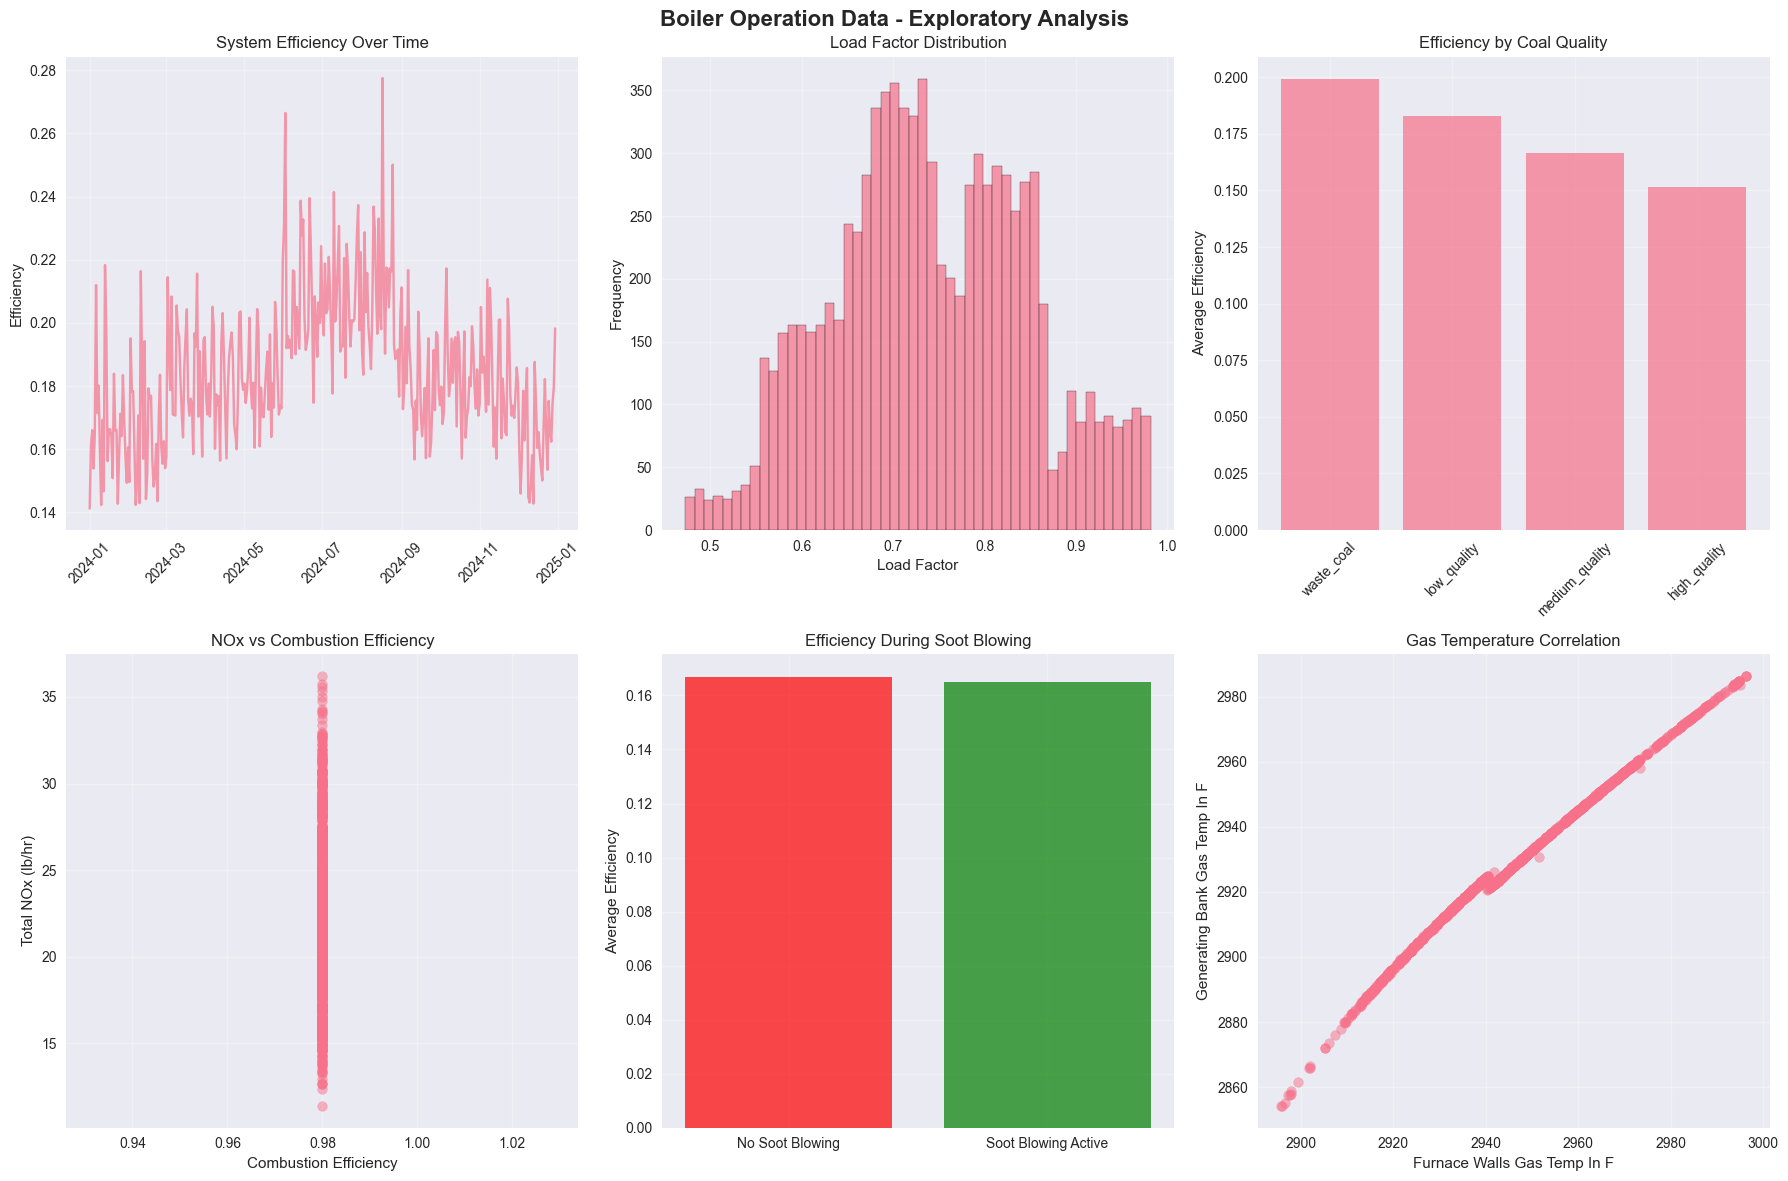

In [6]:
# %%
# =============================================================================
# 5. VISUALIZATION OF KEY TRENDS
# =============================================================================

def create_exploratory_plots(data):
    """Create visualizations to understand the data"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Boiler Operation Data - Exploratory Analysis', fontsize=16, fontweight='bold')
    
    # 1. System efficiency over time
    ax1 = axes[0, 0]
    if 'system_efficiency' in data.columns:
        # Sample data for plotting (every 24th point for daily averages)
        sample_data = data.iloc[::24].copy()
        ax1.plot(sample_data['timestamp'], sample_data['system_efficiency'], alpha=0.7)
        ax1.set_title('System Efficiency Over Time')
        ax1.set_ylabel('Efficiency')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
    
    # 2. Load factor distribution
    ax2 = axes[0, 1]
    if 'load_factor' in data.columns:
        ax2.hist(data['load_factor'], bins=50, alpha=0.7, edgecolor='black')
        ax2.set_title('Load Factor Distribution')
        ax2.set_xlabel('Load Factor')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)
    
    # 3. Coal quality vs efficiency
    ax3 = axes[0, 2]
    if 'coal_quality' in data.columns and 'system_efficiency' in data.columns:
        coal_eff = data.groupby('coal_quality')['system_efficiency'].mean().sort_values(ascending=False)
        ax3.bar(coal_eff.index, coal_eff.values, alpha=0.7)
        ax3.set_title('Efficiency by Coal Quality')
        ax3.set_ylabel('Average Efficiency')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
    
    # 4. NOx vs combustion efficiency
    ax4 = axes[1, 0]
    if 'total_nox_lb_hr' in data.columns and 'combustion_efficiency' in data.columns:
        sample = data.sample(1000)  # Sample for performance
        ax4.scatter(sample['combustion_efficiency'], sample['total_nox_lb_hr'], alpha=0.5)
        ax4.set_title('NOx vs Combustion Efficiency')
        ax4.set_xlabel('Combustion Efficiency')
        ax4.set_ylabel('Total NOx (lb/hr)')
        ax4.grid(True, alpha=0.3)
    
    # 5. Soot blowing impact
    ax5 = axes[1, 1]
    if 'soot_blowing_active' in data.columns and 'system_efficiency' in data.columns:
        soot_eff = data.groupby('soot_blowing_active')['system_efficiency'].mean()
        labels = ['No Soot Blowing', 'Soot Blowing Active']
        ax5.bar(labels, soot_eff.values, alpha=0.7, color=['red', 'green'])
        ax5.set_title('Efficiency During Soot Blowing')
        ax5.set_ylabel('Average Efficiency')
        ax5.grid(True, alpha=0.3)
    
    # 6. Temperature correlation
    ax6 = axes[1, 2]
    temp_cols = [col for col in data.columns if 'temp' in col.lower() and 'gas_temp_in' in col]
    if len(temp_cols) >= 2:
        sample = data.sample(1000)
        ax6.scatter(sample[temp_cols[0]], sample[temp_cols[1]], alpha=0.5)
        ax6.set_title('Gas Temperature Correlation')
        ax6.set_xlabel(temp_cols[0].replace('_', ' ').title())
        ax6.set_ylabel(temp_cols[1].replace('_', ' ').title())
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create exploratory plots
if data is not None:
    create_exploratory_plots(data)

In [7]:
# %%
# =============================================================================
# 6. FEATURE ENGINEERING AND TARGET DEFINITION
# =============================================================================

def engineer_features_and_targets(data, tube_sections):
    """
    Engineer features and define REALISTIC targets for the LSTM model.
    
    REALISTIC TARGETS (what operators actually monitor):
    - Overall heat transfer coefficient (U) degradation
    - Heat transfer effectiveness degradation  
    - Temperature performance degradation
    """
    
    print("🔧 Feature Engineering and Realistic Target Definition")
    print("=" * 60)
    
    # Make a copy for feature engineering
    data_enhanced = data.copy()
    
    # ===== DEFINE REALISTIC TARGETS =====
    print("🎯 Defining REALISTIC targets (observable performance metrics)...")
    
    target_columns = []
    
    for section in tube_sections:
        
        # 1. Overall heat transfer coefficient degradation (PRIMARY TARGET)
        u_col = f'{section}_overall_U_avg'
        if u_col in data.columns:
            # Calculate U degradation from clean baseline
            clean_u = data[u_col].quantile(0.95)  # 95th percentile as "clean" reference
            data_enhanced[f'{section}_U_degradation'] = np.clip(
                (clean_u - data[u_col]) / clean_u, 0, 1
            )
            target_columns.append(f'{section}_U_degradation')
            
            # Rate of degradation (for trending)
            data_enhanced[f'{section}_U_degradation_rate'] = (
                data_enhanced[f'{section}_U_degradation'].diff().fillna(0)
            )
        
        # 2. Heat transfer effectiveness degradation (SECONDARY TARGET)
        heat_col = f'{section}_heat_transfer_btu_hr'
        gas_in_col = f'{section}_gas_temp_in_F'
        water_in_col = f'{section}_water_temp_in_F'
        
        if all(col in data.columns for col in [heat_col, gas_in_col, water_in_col]):
            # Temperature driving force
            temp_driving_force = data[gas_in_col] - data[water_in_col]
            temp_driving_force = temp_driving_force.clip(lower=1)
            
            # Heat transfer effectiveness
            effectiveness = data[heat_col] / temp_driving_force
            max_effectiveness = effectiveness.quantile(0.95)
            
            data_enhanced[f'{section}_effectiveness_degradation'] = np.clip(
                (max_effectiveness - effectiveness) / max_effectiveness, 0, 1
            )
            target_columns.append(f'{section}_effectiveness_degradation')
        
        # 3. Temperature performance degradation (TERTIARY TARGET)
        gas_out_col = f'{section}_gas_temp_out_F'
        if gas_in_col in data.columns and gas_out_col in data.columns and 'load_factor' in data.columns:
            # Actual temperature drop
            actual_temp_drop = data[gas_in_col] - data[gas_out_col]
            
            # Expected temperature drop based on load
            design_temp_drop = actual_temp_drop.quantile(0.95)
            expected_temp_drop = design_temp_drop * data['load_factor']
            expected_temp_drop = expected_temp_drop.clip(lower=1)
            
            # Temperature performance
            temp_performance = actual_temp_drop / expected_temp_drop
            data_enhanced[f'{section}_temp_degradation'] = np.clip(
                1 - temp_performance, 0, 1
            )
            target_columns.append(f'{section}_temp_degradation')
    
    # ===== FEATURE ENGINEERING =====
    print("🔬 Engineering predictive features...")
    
    # 1. Soot production indicators
    if all(col in data.columns for col in ['total_nox_lb_hr', 'combustion_efficiency']):
        data_enhanced['soot_production_indicator'] = (
            data['total_nox_lb_hr'] / data['combustion_efficiency'].clip(lower=0.5)
        )
    
    # 2. Coal quality impact (numeric encoding)
    if 'coal_quality' in data.columns:
        coal_quality_map = {
            'high_quality': 0.8,    # Less degradation
            'medium_quality': 1.0,  # Baseline
            'low_quality': 1.3,     # More degradation
            'waste_coal': 1.6       # Most degradation
        }
        data_enhanced['coal_quality_numeric'] = data['coal_quality'].map(coal_quality_map).fillna(1.0)
    
    # 3. Operational stress factor
    if all(col in data_enhanced.columns for col in ['load_factor', 'coal_quality_numeric', 'combustion_efficiency']):
        data_enhanced['operational_stress'] = (
            data['load_factor'] * 
            data_enhanced['coal_quality_numeric'] * 
            (2.0 - data['combustion_efficiency'].clip(lower=0.5))
        )
    
    # 4. Temperature gradients
    for section in tube_sections:
        gas_in = f'{section}_gas_temp_in_F'
        gas_out = f'{section}_gas_temp_out_F'
        if gas_in in data.columns and gas_out in data.columns:
            data_enhanced[f'{section}_temp_gradient'] = data[gas_in] - data[gas_out]
    
    # 5. System-wide performance metrics
    u_degradation_cols = [col for col in target_columns if 'U_degradation' in col]
    if len(u_degradation_cols) > 1:
        data_enhanced['system_wide_degradation'] = data_enhanced[u_degradation_cols].mean(axis=1)
        data_enhanced['degradation_variation'] = data_enhanced[u_degradation_cols].std(axis=1)
    
    # 6. Cyclical time encoding
    if 'timestamp' in data.columns:
        data_enhanced['hour'] = data_enhanced['timestamp'].dt.hour
        data_enhanced['day_of_year'] = data_enhanced['timestamp'].dt.dayofyear
        data_enhanced['month'] = data_enhanced['timestamp'].dt.month
        
        # Cyclical encoding
        data_enhanced['hour_sin'] = np.sin(2 * np.pi * data_enhanced['hour'] / 24)
        data_enhanced['hour_cos'] = np.cos(2 * np.pi * data_enhanced['hour'] / 24)
        data_enhanced['season_sin'] = np.sin(2 * np.pi * data_enhanced['day_of_year'] / 365.25)
        data_enhanced['season_cos'] = np.cos(2 * np.pi * data_enhanced['day_of_year'] / 365.25)
    
    # ===== FEATURE SELECTION =====
    
    # Core predictive features
    feature_categories = {
        'combustion': [
            'thermal_nox_lb_hr', 'fuel_nox_lb_hr', 'total_nox_lb_hr',
            'excess_o2_pct', 'combustion_efficiency', 'flame_temp_F'
        ],
        'coal': [
            'coal_carbon_pct', 'coal_volatile_matter_pct', 'coal_sulfur_pct',
            'coal_ash_pct', 'coal_moisture_pct', 'coal_heating_value_btu_lb'
        ],
        'operating': [
            'load_factor', 'coal_rate_lb_hr', 'air_flow_scfh',
            'fuel_input_btu_hr', 'flue_gas_flow_lb_hr'
        ],
        'environmental': [
            'ambient_temp_F', 'ambient_humidity_pct'
        ],
        'soot_blowing': [
            'soot_blowing_active', 'sections_cleaned_count'
        ] + [f'{section}_hours_since_cleaning' for section in tube_sections],
        'temporal': [
            'hour_sin', 'hour_cos', 'season_sin', 'season_cos'
        ]
    }
    
    # Add section-specific temperatures
    for section in tube_sections:
        feature_categories['temperatures'] = feature_categories.get('temperatures', []) + [
            f'{section}_gas_temp_in_F', f'{section}_gas_temp_out_F',
            f'{section}_water_temp_in_F', f'{section}_water_temp_out_F'
        ]
    
    # Add engineered features
    engineered_features = [col for col in data_enhanced.columns if any(suffix in col for suffix in [
        'soot_production_indicator', 'coal_quality_numeric', 'operational_stress',
        '_temp_gradient', 'system_wide_degradation', 'degradation_variation'
    ])]
    
    # Compile all features
    all_features = []
    for category, features in feature_categories.items():
        valid_features = [f for f in features if f in data_enhanced.columns]
        all_features.extend(valid_features)
        print(f"   • {category}: {len(valid_features)} features")
    
    all_features.extend(engineered_features)
    print(f"   • engineered: {len(engineered_features)} features")
    
    # Remove duplicates
    feature_columns = list(dict.fromkeys(all_features))
    
    print(f"\n✅ Feature engineering complete:")
    print(f"   • Total features: {len(feature_columns)}")
    print(f"   • Total targets: {len(target_columns)}")
    print(f"   • Target sections: {len(tube_sections)}")
    
    print(f"\n💡 REALISTIC TARGETS DEFINED:")
    for target in target_columns[:6]:  # Show first 6
        print(f"   ✅ {target}")
    if len(target_columns) > 6:
        print(f"   ... and {len(target_columns) - 6} more targets")
    
    return data_enhanced, feature_columns, target_columns

# Engineer features and targets
if data is not None:
    data_enhanced, feature_columns, target_columns = engineer_features_and_targets(data, config.TUBE_SECTIONS)
    
    print(f"\n📊 Data shape after feature engineering: {data_enhanced.shape}")
    print(f"📋 Available features: {len(feature_columns)}")
    print(f"🎯 Prediction targets: {len(target_columns)}")

🔧 Feature Engineering and Realistic Target Definition
🎯 Defining REALISTIC targets (observable performance metrics)...
🔬 Engineering predictive features...
   • combustion: 6 features
   • coal: 6 features
   • operating: 5 features
   • environmental: 2 features
   • soot_blowing: 9 features
   • temporal: 4 features
   • temperatures: 28 features
   • engineered: 12 features

✅ Feature engineering complete:
   • Total features: 72
   • Total targets: 21
   • Target sections: 7

💡 REALISTIC TARGETS DEFINED:
   ✅ furnace_walls_U_degradation
   ✅ furnace_walls_effectiveness_degradation
   ✅ furnace_walls_temp_degradation
   ✅ generating_bank_U_degradation
   ✅ generating_bank_effectiveness_degradation
   ✅ generating_bank_temp_degradation
   ... and 15 more targets

📊 Data shape after feature engineering: (8760, 186)
📋 Available features: 72
🎯 Prediction targets: 21


## EDA

In [14]:
soot_columns = [col for col in data_enhanced.columns if "soot" in col.lower()]
temperature_columns =  [col for col in data_enhanced.columns if "temp" in col.lower()]
temperature_columns.remove('attemperator_flow_lb_hr')
print(soot_columns)
print(temperature_columns)
print(target_columns)

['soot_blowing_active', 'furnace_walls_soot_blowing_active', 'generating_bank_soot_blowing_active', 'superheater_primary_soot_blowing_active', 'superheater_secondary_soot_blowing_active', 'economizer_primary_soot_blowing_active', 'economizer_secondary_soot_blowing_active', 'air_heater_soot_blowing_active', 'soot_production_indicator']
['ambient_temp_F', 'flame_temp_F', 'final_steam_temp_F', 'stack_temp_F', 'furnace_walls_gas_temp_in_F', 'furnace_walls_gas_temp_out_F', 'furnace_walls_water_temp_in_F', 'furnace_walls_water_temp_out_F', 'generating_bank_gas_temp_in_F', 'generating_bank_gas_temp_out_F', 'generating_bank_water_temp_in_F', 'generating_bank_water_temp_out_F', 'superheater_primary_gas_temp_in_F', 'superheater_primary_gas_temp_out_F', 'superheater_primary_water_temp_in_F', 'superheater_primary_water_temp_out_F', 'superheater_secondary_gas_temp_in_F', 'superheater_secondary_gas_temp_out_F', 'superheater_secondary_water_temp_in_F', 'superheater_secondary_water_temp_out_F', 'econo

<Axes: >

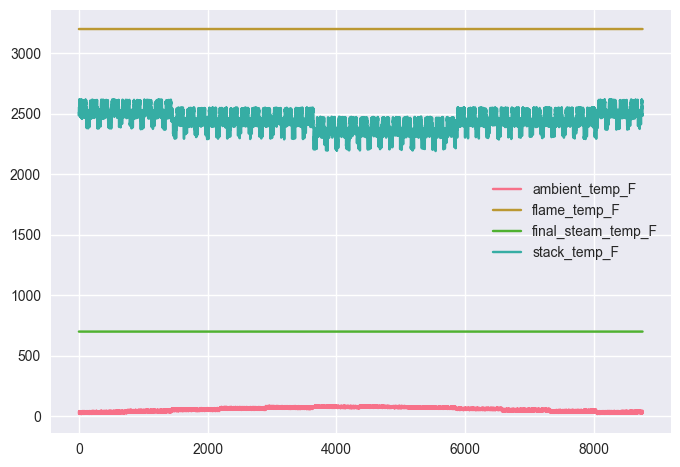

In [17]:
data_enhanced[temperature_columns[:4]].plot()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

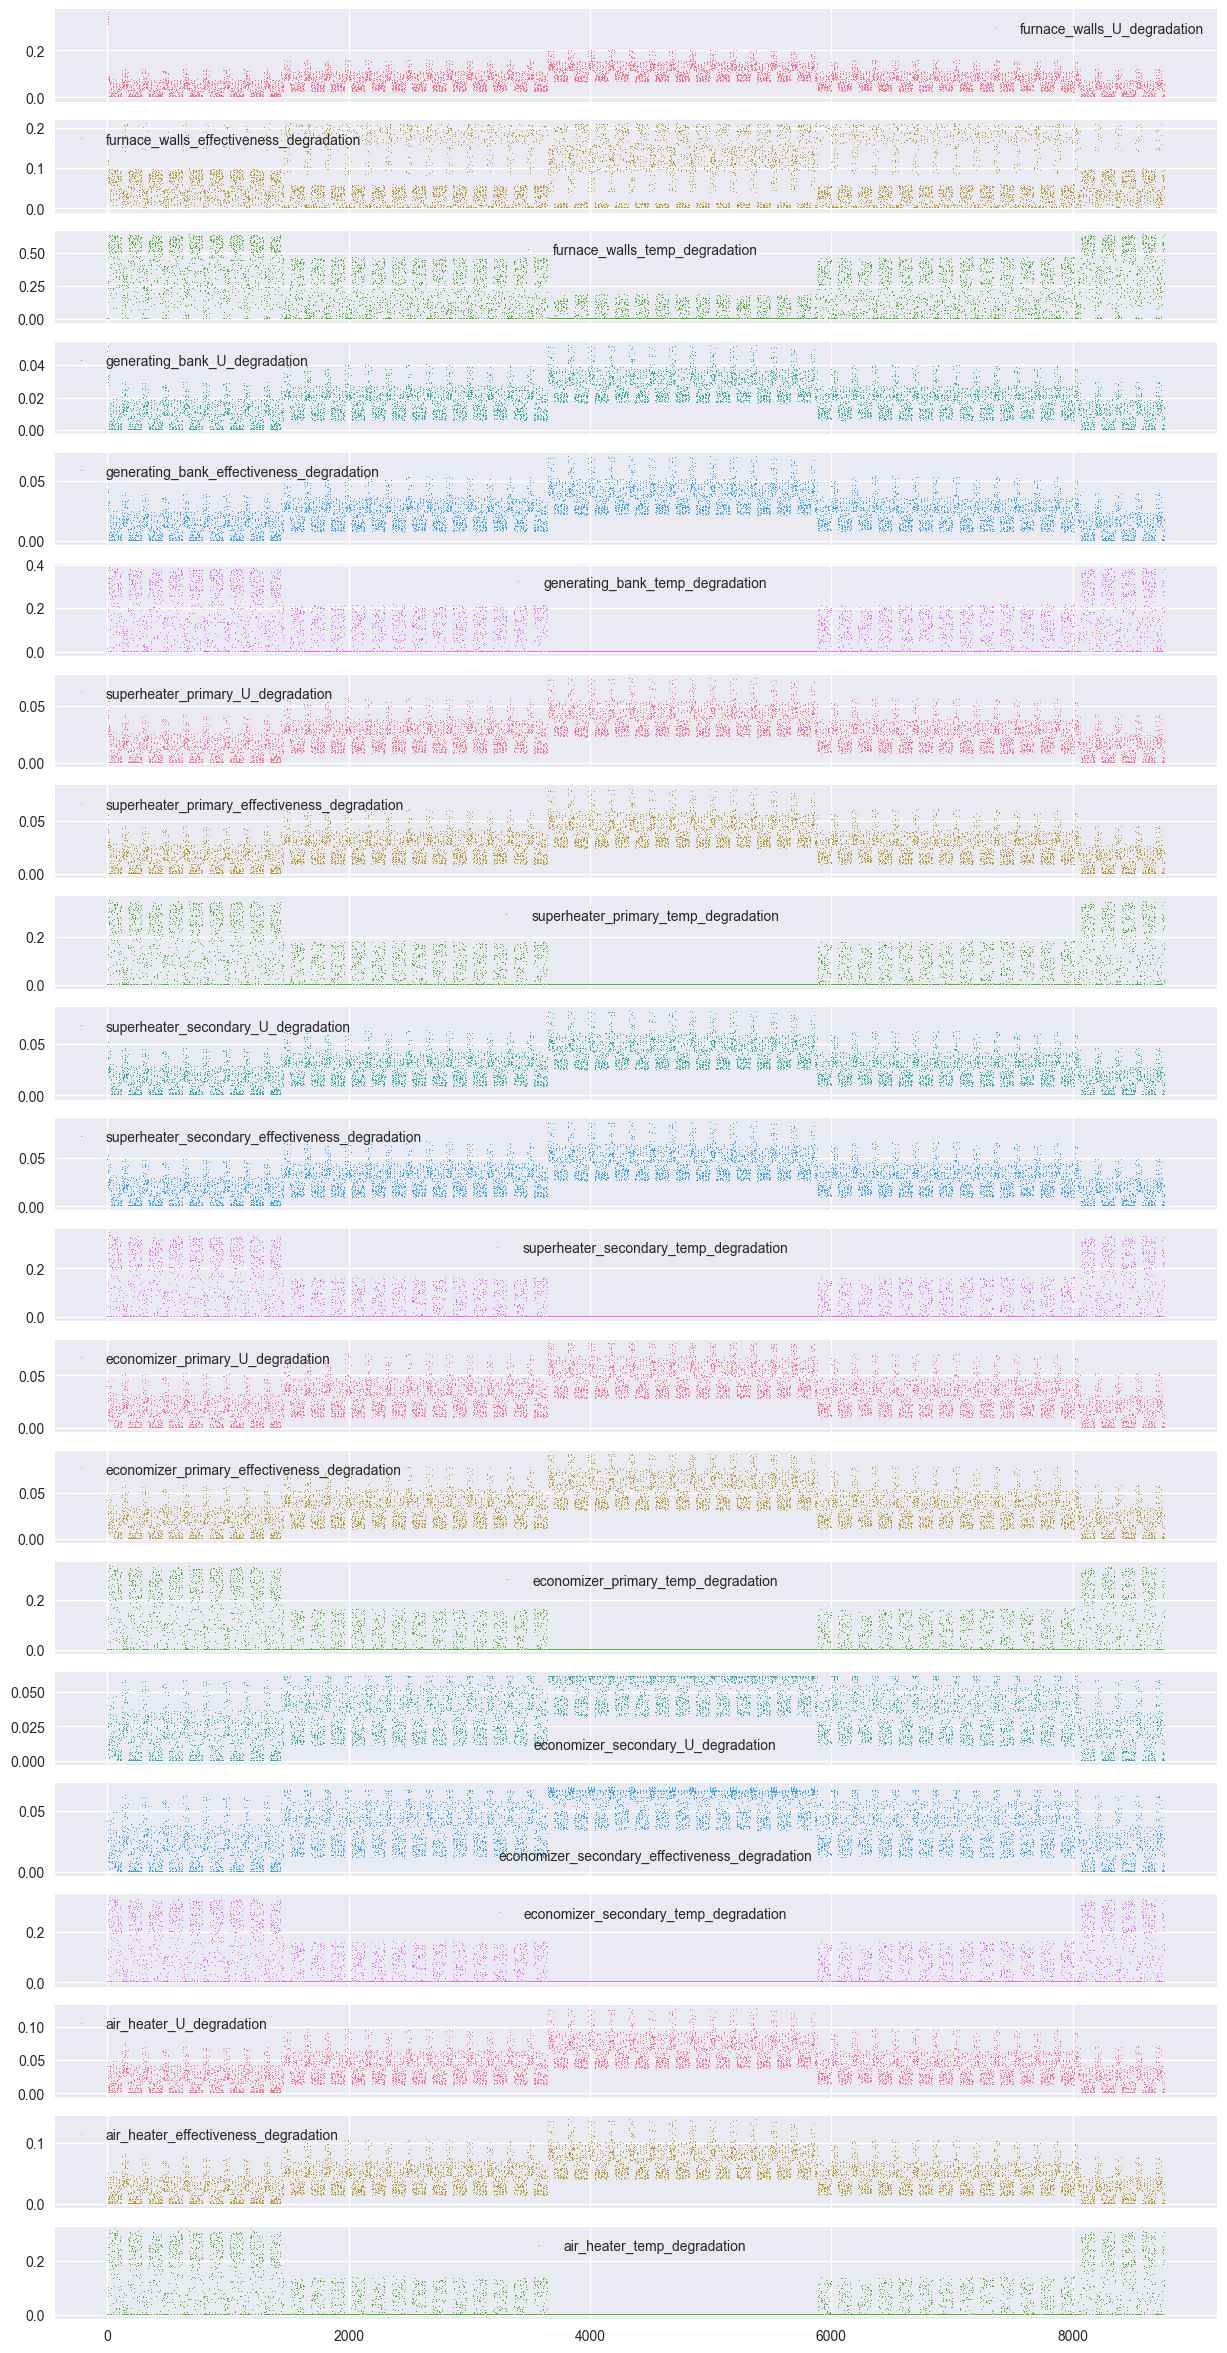

In [13]:
data_enhanced[target_columns].plot(subplots=True,marker=',',linestyle='None',figsize=(15,30))